# Analyse de Churn : Modélisation Baseline

Ce notebook a pour objectif de tester différents modèles de machine learning pour prédire les clients à risque de résiliation (churn). 

## Contexte
- L’analyse exploratoire des données (EDA) a été réalisée dans un autre notebook. 
- Ici, on se concentre uniquement sur la **modélisation baseline** pour comparer les performances de plusieurs modèles.

## Approche
- **Modèles testés** : Régression Logistique, Forêt Aléatoire, et MLP.
- **Métriques utilisées** : Matrice de confusion, rapport de classification, scores de précision, rappel et F1.

L’objectif final est de déterminer le modèle le plus prometteur pour guider les étapes futures d’optimisation ou de déploiement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Chemin du fichier CSV contenant les données
path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'

# Chargement des données dans un DataFrame pandas
data = pd.read_csv(path)

In [3]:
# Liste des colonnes sélectionnées pour la modélisation
# Ces colonnes incluent les charges mensuelles, la durée d'abonnement, et divers services ou options liés au client.
features = ['MonthlyCharges', 'tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaymentMethod']

In [4]:
# Création des jeux de données X et y
# X contient les caractéristiques (features) sélectionnées.
X = data[features].copy()

# y est la variable cible (Churn : 1 pour 'Oui', 0 pour 'Non')
# Les valeurs manquantes ou non renseignées sont remplacées par NaN.
y = data['Churn'].copy()
y.replace({'Yes': 1, 'No': 0, ' ': np.nan}, inplace=True)

/var/folders/m4/p71xrbqx639250tkt6rzcx940000gn/T/ipykernel_86879/809066748.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({'Yes': 1, 'No': 0, ' ': np.nan}, inplace=True)


In [5]:
# Vérification du nombre de valeurs manquantes par colonne dans X
X.isna().sum()

MonthlyCharges      0
tenure              0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaymentMethod       0
dtype: int64

### Préparation des données pour l'entraînement

Dans cette section, nous préparons les données pour entraîner nos modèles. Les étapes comprennent :

- La création d'un préprocesseur pour appliquer des transformations spécifiques aux colonnes numériques et catégoriques :
  - **Colonnes numériques** : Mise à l'échelle avec `MinMaxScaler`.
  - **Colonnes catégoriques** : Encodage en variables binaires avec `OneHotEncoder`.
- La division des données en ensembles d'entraînement et de test, tout en préservant la distribution des classes.
- L'application des transformations définies dans le préprocesseur.
- La conversion des résultats transformés en DataFrames pour une manipulation plus facile.

Ces étapes assurent que les données sont dans un format adapté aux algorithmes de machine learning.

In [6]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split

# Création d'un préprocesseur pour transformer les colonnes :
# - Mise à l'échelle des colonnes numériques avec MinMaxScaler
# - Encodage des colonnes catégoriques en variables binaires avec OneHotEncoder
preprocessor = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(), make_column_selector(dtype_include=object))
)

# Division des données en ensembles d'entraînement et de test
# La stratification est utilisée pour préserver la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Réinitialisation des index des ensembles cible pour éviter tout décalage
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# Application du préprocesseur : 
# - fit_transform() ajuste le préprocesseur sur l'ensemble d'entraînement et applique les transformations
X_train = preprocessor.fit_transform(X_train)

# - transform() applique uniquement les transformations sur l'ensemble de test
X_test = preprocessor.transform(X_test)

# Conversion des matrices transformées en DataFrames pour une meilleure lisibilité
X_train = pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers

### Création et Compilation du Modèle MLP

Dans cette section, nous définissons et compilons un modèle de réseau de neurones (Multilayer Perceptron - MLP) pour la classification binaire. 

#### Étapes réalisées :
1. **Création du modèle** :
   - Utilisation de l'API Keras Sequential pour empiler les couches du modèle.
   - Les couches denses (fully connected) utilisent la fonction d'activation ReLU pour introduire de la non-linéarité.
   - Ajout de **Dropout** pour réduire le surapprentissage.
   - Ajout de la **normalisation batch** pour stabiliser et accélérer l'entraînement.
   - La couche de sortie utilise une fonction sigmoïde pour produire une probabilité.

2. **Compilation du modèle** :
   - Optimiseur : `Adam` avec un taux d'apprentissage de \(10^{-4}\).
   - Fonction de perte : `binary_crossentropy` pour un problème de classification binaire.
   - Métriques : `binary_accuracy`, `f1_score`, et `AUC` pour évaluer les performances.

Ce modèle est conçu pour prédire la probabilité de churn en se basant sur les caractéristiques prétraitées des clients.

In [9]:
# Définition du modèle séquentiel avec Keras
# Couche dense avec 128 neurones et activation ReLU, prenant en entrée la taille des features
# Ajout de couches Dropout pour réduire le surapprentissage (30%)
# Normalisation des activations pour stabiliser et accélérer l'entraînement
# Couche de sortie avec un neurone et activation sigmoïde pour produire une probabilité

mlp = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

/opt/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Définition de l'optimiseur : Adam avec un taux d'apprentissage de 1e-4
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compilation du modèle
mlp.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['binary_accuracy', 'AUC']
)

In [11]:
# Conversion des valeurs de la variable cible (y_train et y_test) en entiers
# Cela garantit que les valeurs sont au format attendu pour les calculs et la modélisation
y_train = y_train.astype(int)
y_test = y_test.astype(int)

### Gestion du déséquilibre des classes

Dans cette section, nous préparons les données pour gérer un déséquilibre éventuel entre les classes de la variable cible.

#### Étapes réalisées :
1. **Conversion des types** : 
   Les labels `y_train` et `y_test` sont convertis en entiers pour garantir leur compatibilité avec les modèles.

2. **Calcul du déséquilibre** :
   Le nombre d'exemples dans chaque classe (0 et 1) est calculé :
   - **Classe 0** : Nombre d'exemples appartenant à la classe négative.
   - **Classe 1** : Nombre d'exemples appartenant à la classe positive.

3. **Calcul des poids des classes** :
   Les poids sont attribués de manière à compenser les déséquilibres dans les classes.
   - Les poids sont proportionnels à l'inverse de la fréquence de chaque classe.
   - Cela garantit que les classes rares ont un impact suffisant lors de l'entraînement du modèle.

In [12]:
# Calcul du nombre d'exemples dans chaque classe
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
total = neg + pos

In [13]:
# Calcul des poids pour chaque classe afin de gérer un déséquilibre des classes
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

# Création d'un dictionnaire des poids pour chaque classe
class_weight = {0: weight_for_0, 1: weight_for_1}

# Affichage des poids calculés pour chaque classe
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


### Entraînement du modèle et suivi des performances

Dans cette étape, le modèle MLP est entraîné avec les données d'entraînement. Nous utilisons :
- Une validation croisée avec 20 % des données d'entraînement pour évaluer les performances en cours d'entraînement.
- Une gestion du déséquilibre des classes grâce à des poids calculés pour chaque classe.

Nous visualisons ensuite les courbes :
- **Perte d'entraînement et de validation**.
- **Précision binaire d'entraînement et de validation**.
- **AUC (Area Under Curve)** d'entraînement et de validation.

<Axes: >

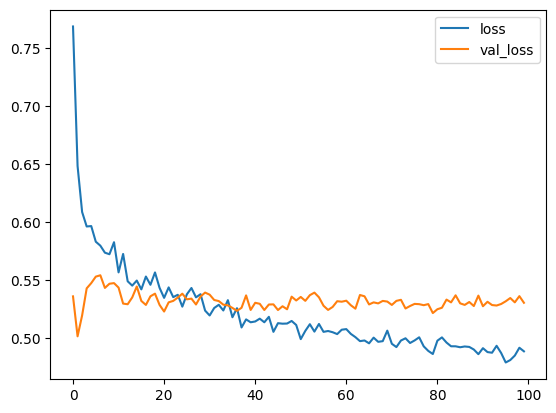

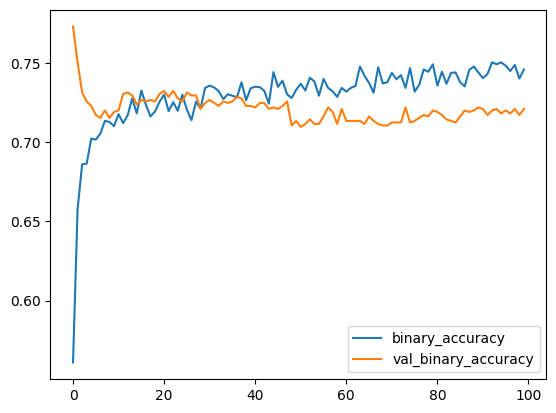

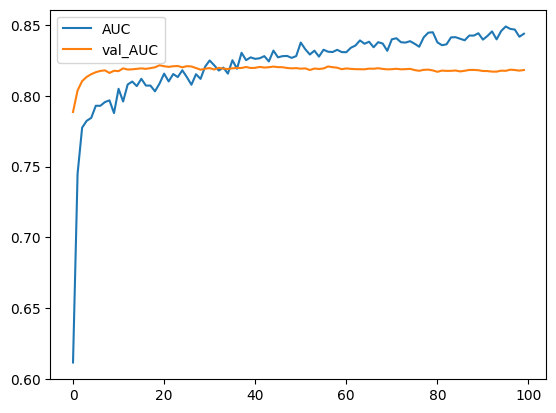

In [14]:
# Entraînement du modèle MLP
history = mlp.fit(
    X_train, y_train,             # Données d'entraînement
    validation_split=0.2,         # 20 % des données d'entraînement utilisées pour la validation
    batch_size=32,                # Taille des lots pour l'entraînement
    epochs=100,                   # Nombre d'époques
    class_weight=class_weight,    # Gestion du déséquilibre des classes
    verbose=0                     # Mode silencieux pour limiter les sorties
)

# Création d'un DataFrame pour stocker l'historique d'entraînement
history_df = pd.DataFrame(history.history)

# Visualisation des pertes (entraînement et validation)
history_df.loc[:, ['loss', 'val_loss']].plot()

# Visualisation de la précision binaire (entraînement et validation)
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

# Visualisation de l'AUC (entraînement et validation)
history_df.loc[:, ['AUC', 'val_AUC']].plot()

## Évaluation des performances des modèles

L'évaluation des performances des modèles est réalisée en trois étapes similaires pour chacun des modèles (Régression Logistique, Forêt Aléatoire et MLP) :

1. **Prédictions** : 
   - Les modèles prédisent les labels pour les données de test. 
   - Les modèles qui retournent des probabilités (comme le MLP) utilisent un seuil de 0,5 pour convertir les probabilités en classes.

2. **Rapport de classification** : 
   - Génération d'un rapport contenant les métriques principales :
     - **Précision** : Proportion des prédictions correctes parmi celles effectuées.
     - **Rappel** : Proportion des exemples positifs correctement prédits.
     - **F1-Score** : Moyenne harmonique de la précision et du rappel.
     - **Support** : Nombre d'exemples pour chaque classe.

3. **Matrice de confusion** :
   - Permet d'analyser les erreurs de classification en montrant les vrais positifs, faux positifs, vrais négatifs et faux négatifs.

Les résultats sont affichés de manière similaire pour chaque modèle, facilitant ainsi la comparaison.

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1294
           1       0.51      0.78      0.61       467

    accuracy                           0.74      1761
   macro avg       0.70      0.75      0.71      1761
weighted avg       0.80      0.74      0.75      1761



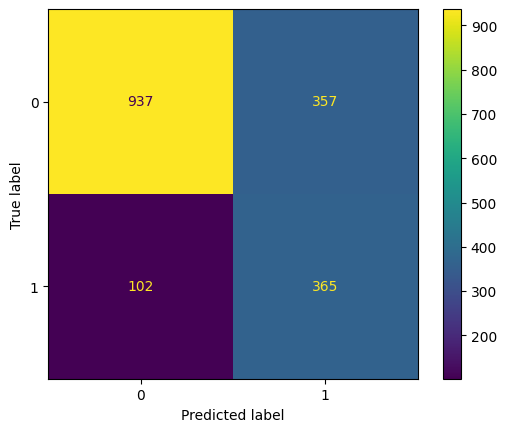

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur les données de test
# Le modèle retourne des probabilités, converties en classes binaires avec un seuil de 0,5
y_pred_mlp = mlp.predict(X_test)
y_pred_mlp = (y_pred_mlp > 0.5).astype(int)  # Convertir les probabilités en classes (0 ou 1)

# Affichage du rapport de classification
# Contient les métriques de précision, rappel, F1-score et support pour chaque classe
print(classification_report(y_test, y_pred_mlp))

# Calcul de la matrice de confusion
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Affichage visuel de la matrice de confusion
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=[0, 1])
disp_mlp.plot()

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1294
           1       0.51      0.80      0.62       467

    accuracy                           0.74      1761
   macro avg       0.71      0.76      0.71      1761
weighted avg       0.80      0.74      0.75      1761



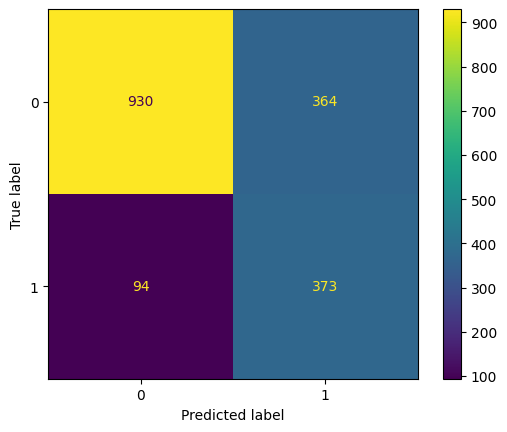

In [16]:
from sklearn.linear_model import LogisticRegression

# Initialiser le modèle de régression logistique
logreg = LogisticRegression(
    solver='lbfgs',         # Algorithme d'optimisation efficace
    penalty='l2',           # Régularisation standard
    C=1.0,                  # Hyperparamètre de régularisation
    max_iter=1000,          # Nombre maximum d'itérations
    class_weight=class_weight  # Gestion du déséquilibre des classes
)

# Entraîner le modèle
logreg.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred = logreg.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

# Calcul et affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()


              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1294
           1       0.55      0.73      0.63       467

    accuracy                           0.77      1761
   macro avg       0.72      0.76      0.73      1761
weighted avg       0.80      0.77      0.78      1761



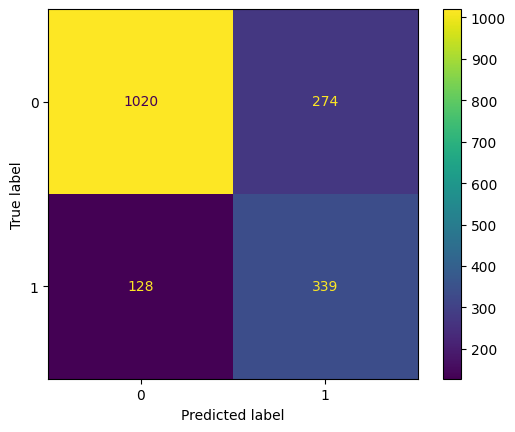

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialiser le modèle de forêt aléatoire
rf_model = RandomForestClassifier(
    n_estimators=350,            # Nombre d'arbres dans la forêt
    class_weight=class_weight,   # Gestion du déséquilibre des classes
    random_state=0,              # Pour la reproductibilité
    max_depth=10,                # Profondeur maximale des arbres
    min_samples_split=2,         # Nombre minimum d'échantillons pour une division
    criterion='entropy'          # Critère de sélection des divisions
)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred_rf))

# Calcul et affichage de la matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot()

## Conclusion

Les résultats obtenus avec les trois modèles (MLP, Régression Logistique et Forêt Aléatoire) sont encourageants et montrent un potentiel significatif pour prédire les clients à risque de résiliation. Ces modèles permettent déjà d'obtenir des performances satisfaisantes, mais un choix doit être fait pour la suite des travaux en fonction des besoins spécifiques.

### Analyse comparative
- **MLP et Régression Logistique** : 
  - Ces deux modèles ont des résultats similaires, ce qui est cohérent étant donné leur nature. 
  - Tous deux minimisent efficacement les faux négatifs, ce qui est crucial dans ce projet pour détecter les clients à risque.
- **Forêt Aléatoire** : 
  - Bien que ce modèle soit robuste, il est plus complexe et moins bien adapté ici, car il ne priorise pas suffisamment la minimisation des faux négatifs par rapport aux autres modèles.

### Décision finale
Dans le cadre de ce projet, où l'objectif principal est de minimiser les faux négatifs (afin de détecter un maximum de clients à risque), la Régression Logistique se distingue comme le modèle le plus pertinent. Elle offre :
- Une **simplicité** d'interprétation et de mise en œuvre.
- Des performances légèrement meilleures que le MLP sur les métriques importantes.

Pour les étapes futures, la Régression Logistique sera donc choisie comme point de départ pour développer un modèle optimisé capable de mieux cibler les clients à risque de résiliation.